In [1]:
import numpy as np
import torch
import sys
from utils import *
from matplotlib import pyplot as plt
import torch.nn as nn
import time
from numba import cuda
from tqdm import tqdm, trange
import os
import pyroc
import pandas as pd
import gc
from IPython.display import clear_output
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="7"  
device = torch.device("cuda:0")
dtype = torch.float32
torch.manual_seed(42)
np.random.seed(42)

/math/home/eruisun/software/anaconda/envs/LFI/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def free_gpu_cache():
    torch.cuda.empty_cache()
    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)
#free_gpu_cache()

In [3]:

H = 500
out= 100
L = 1
class DN(torch.nn.Module):
    def __init__(self, H=300, out=100):
        super(DN, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, out, bias=True),
        )
    def forward(self, input):
        output = self.model(input)
        return output

class another_DN(torch.nn.Module):
    def __init__(self, H=300, out=100):
        super(another_DN, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, 28, bias=True),
        )
    def forward(self, input):
        output = self.model(input) + input
        return output

class Classifier(torch.nn.Module):
    def __init__(self, H=300, layers = 5):
        super(Classifier, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, 1, bias=True),
            torch.nn.Sigmoid(),
        )
        if layers == 6:
            self.model = torch.nn.Sequential(
                torch.nn.Linear(28, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, 1, bias=True),
                torch.nn.Sigmoid(),
            )
    def forward(self, input):
        output = self.model(input)
        return output

In [4]:
dataset = np.load('HIGGS.npy')
dataset_P = dataset[dataset[:,0]==0][:, 1:] # background (5829122, 28)
dataset_Q = dataset[dataset[:,0]==1][:, 1:] # signal     (5170877, 28)

# 画ROC

In [5]:
path_LFI = './checkpoint1300008/30/'
path_Fea_G = './checkpoint1300016/60/'
path_Gaussian = './Gaussian/checkpoint1299999/800/'
path_Scheffe = './Scheffe/checkpoint1299999/50/'
path_dict_roc = {
    'MMD-L': path_LFI,
    #'MMD-G': path_Fea_G,
    'MMD-O': path_Gaussian,
    'Scheffe': path_Scheffe,
}

100%|██████████| 3/3 [00:21<00:00,  7.02s/it]


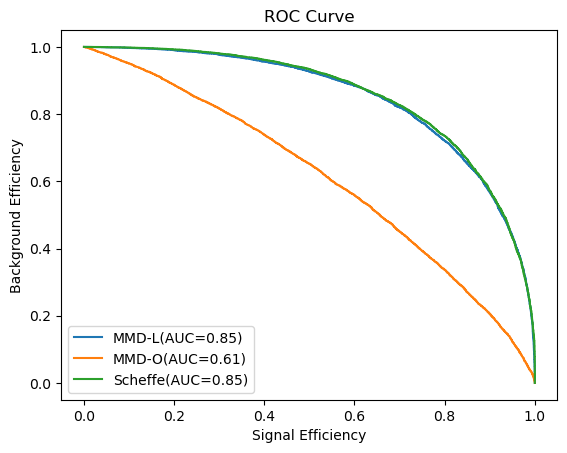

ROC saved at ROC_curve.pdf


In [6]:
for key in tqdm(path_dict_roc):
    path = path_dict_roc[key]
    if key == 'Scheffe':
        model = Classifier(300, 6).to(device)
    if key == 'MMD-O':
        model = DN(300, 100).to(device)
    if key == 'MMD-L':
        model = DN(300, 100).to(device)
    another_model = another_DN().to(device)
    model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst = load_model(model, another_model, path)
    gc.collect()
    torch.cuda.empty_cache()
    with torch.no_grad():
        M = 10000
        Z = np.concatenate((dataset_P[np.random.choice(dataset_P.shape[0], M, replace=False)],
                    dataset_Q[np.random.choice(dataset_Q.shape[0], M, replace=False)]), axis=0)
        Z = MatConvert(Z, device, dtype)
        PQhat = compute_score_func(Z, dataset_P, dataset_Q, 
                    model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst, M=10000)
        PQhat = PQhat.cpu().detach().numpy()
        auc, x, y = get_auc_and_x_and_y(PQhat)
        label = key+'(AUC={:.2f})'.format(auc.item())
        plt.plot(x, y, label=label)
        p = get_pval(PQhat[:M], PQhat[M:])*np.sqrt(1100)
        print('p-value = %.3f'%p)
        clear_output(wait=True)
plt.legend()
plt.xlabel('Signal Efficiency')
plt.ylabel('Background Efficiency')
plt.title('ROC Curve')
plt.savefig('ROC_curve.pdf', dpi = 3000)
plt.show()
print('ROC saved at ROC_curve.pdf')


In [7]:
gc.collect()
torch.cuda.empty_cache()

# 画 p value - n

In [37]:
def get_ps(path_dict, method):
    print('-------- start get_ps --------')
    ps = np.zeros(len(path_dict))
    ps_thres = np.zeros(len(path_dict))
    for i, key in enumerate(path_dict):
        path = path_dict[key]
        if method == 'Scheffe':
            model = Classifier(300, 6).cuda()
        if method == 'MMD-O':
            model = DN(300, 100).cuda()
        if method == 'MMD-L':
            model = DN(300, 100).cuda()
        if method == 'MMD-G':
            model = DN(300, 100).cuda()
        another_model = another_DN(300, 100).cuda()
        model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst = load_model(model, another_model, path)
        gc.collect()
        torch.cuda.empty_cache()
        M = 10000
        Z = np.concatenate((dataset_P[np.random.choice(dataset_P.shape[0], M, replace=False)],
                    dataset_Q[np.random.choice(dataset_Q.shape[0], M, replace=False)]), axis=0)
        Z = MatConvert(Z, device, dtype)
        PQhat = compute_score_func(Z, dataset_P, dataset_Q, 
                    model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst,
                    M = 1000)
        PQhat = PQhat.cpu().detach().numpy()
        p = get_pval(PQhat[:M], PQhat[M:])*np.sqrt(1100)
        ps[i] = p
        p_thres = get_thres_pval(PQhat)
        ps_thres[i] = p_thres
        print('n = %d'%key, ', p-value = %.3f'%p, 'p-value_thres = %.3f'%p_thres)
    return ps, ps_thres

ns = np.array([1300000, 1000000, 700000, 400000, 100000, 50000])
ps_L = ps_G = ps_O = ps_S = np.zeros(ns.shape[0])

In [52]:
# MMD-L
path_dict = {    
    1300000: './checkpoint1300101/25/',
    1000000: './checkpoint1000101/25/',
    700000: './checkpoint700001/40/',
    400000: './checkpoint400000/60/',
    100000: './checkpoint100000/60/',
    50000: './checkpoint50000/50/',
}
ps_L, ps_L_thres = get_ps(path_dict, 'MMD-L')
clear_output()
ps_L, ps_L_thres


(array([4.50668486, 4.4428132 , 4.60061008, 4.18193666, 3.32478914,
        2.82228594]),
 array([5.04685009, 5.01714449, 4.85007337, 4.16859295, 3.26921302,
        2.64112395]))

In [47]:
# MMD-G
path_dict = {
    1300000: './Fea_Gau/checkpoint1300000/35/',
    1000000: './Fea_Gau/checkpoint1000000/35/',
    700000: './Fea_Gau/checkpoint700000/30/',
    400000: './Fea_Gau/checkpoint400000/30/',
    100000: './Fea_Gau/checkpoint100000/30/',
    50000: './Fea_Gau/checkpoint50000/30/',
}
ps_G, ps_G_thres = get_ps(path_dict, 'MMD-G')
clear_output()


In [59]:
# MMD-O
path_dict = {
    1300000: './Gaussian/checkpoint1299999/800/',
    1000000: './Gaussian/checkpoint1000000/430/',
    700000: './Gaussian/checkpoint700000/20/',
    400000: './Gaussian/checkpoint400000/10/',
    100000: './Gaussian/checkpoint100000/20/',
    50000: './Gaussian/checkpoint50000/40/',
}
ps_O, ps_O_thres = get_ps(path_dict, 'MMD-O')
clear_output()

In [57]:
# Scheffe
path_dict = {
    1300000: './Scheffe/checkpoint1299999/50/',
    1000000: './Scheffe/checkpoint1000000/30/',
    700000: './Scheffe/checkpoint700000/60/',
    400000: './Scheffe/checkpoint400000/60/',
    100000: './Scheffe/checkpoint100000/60/',
    50000: './Scheffe/checkpoint50000/60/',
}
ps_S, ps_S_thres = get_ps(path_dict, 'Scheffe')
clear_output()

p-n saved at p_n_curve.pdf


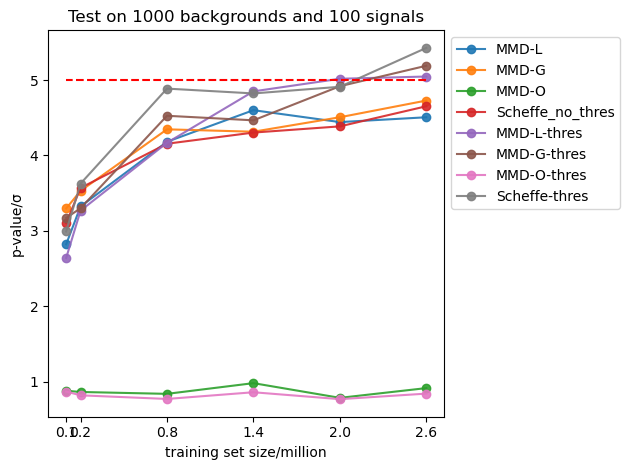

In [60]:
# for ps in [ps_L, ps_G, ps_O, ps_S]:
#     ps = ps /(1/11*np.sqrt(1100)) * (1/10.5*np.sqrt(1050))
ns = np.array([1300000, 1000000, 700000, 400000, 100000, 50000])
# 直接求和
plt.plot(ns, ps_L, label='MMD-L', marker='o', alpha=0.9)
plt.plot(ns, ps_G, label='MMD-G', marker='o', alpha=0.9)
plt.plot(ns, ps_O, label='MMD-O', marker='o', alpha=0.9)
plt.plot(ns, ps_S, label='Scheffe_no_thres', marker='o', alpha=0.9)
# 加上threshold
plt.plot(ns, ps_L_thres, label='MMD-L-thres', marker='o', alpha=0.9)
plt.plot(ns, ps_G_thres, label='MMD-G-thres', marker='o', alpha=0.9)
plt.plot(ns, ps_O_thres, label='MMD-O-thres', marker='o', alpha=0.9)
plt.plot(ns, ps_S_thres, label='Scheffe-thres', marker='o', alpha=0.9)

plt.legend(bbox_to_anchor =(1, 1))
plt.xlabel('training set size/million')
plt.xticks(ns, ns*2/10**6)
plt.ylabel('p-value/σ')
plt.plot(ns, 5*np.ones(ns.shape[0]), 'r--')
plt.title('Test on 1000 backgrounds and 100 signals')
plt.tight_layout()
plt.savefig('p_n_curve.pdf')
plt.savefig('p_n_curve.png')
print('p-n saved at p_n_curve.pdf')
plt.show()



# 画training of LFI

In [14]:
gc.collect()
torch.cuda.empty_cache()
model = DN(300, 100).to(device)
another_model = another_DN(300).to(device)

epoch_list = np.arange(0,176,10)

p_epoch = np.zeros(epoch_list.shape[0])
p_thres_epoch = np.zeros(epoch_list.shape[0])
pat = './checkpoint999999/'
J_epoch = np.load(pat+'J_star_u.npy')
J_valid_epoch = np.load(pat+'J_validations.npy')
mmd_epoch = np.load(pat+'mmd_val_record.npy')

for i, epoch in tqdm(enumerate(epoch_list)):
    path = './checkpoint999999/%d/'%epoch
    model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst = load_model(model, another_model, path)
    M = 10000
    Z = np.concatenate((dataset_P[np.random.choice(dataset_P.shape[0], M, replace=False)],
        dataset_Q[np.random.choice(dataset_Q.shape[0], M, replace=False)]), axis=0)
    Z = MatConvert(Z, device, dtype)
    PQhat = compute_score_func(Z, dataset_P, dataset_Q, 
                model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst,
                M = 10000)
    PQhat = PQhat.cpu().detach().numpy()
    p_epoch[i] = get_pval(PQhat[:M], PQhat[M:])*np.sqrt(1100)
    p_thres_epoch[i] = get_thres_pval(PQhat)
    clear_output(wait = True)
    print(p_epoch[i], p_thres_epoch[i])


18it [03:11, 10.62s/it]

4.40068448091644 4.720983350039573


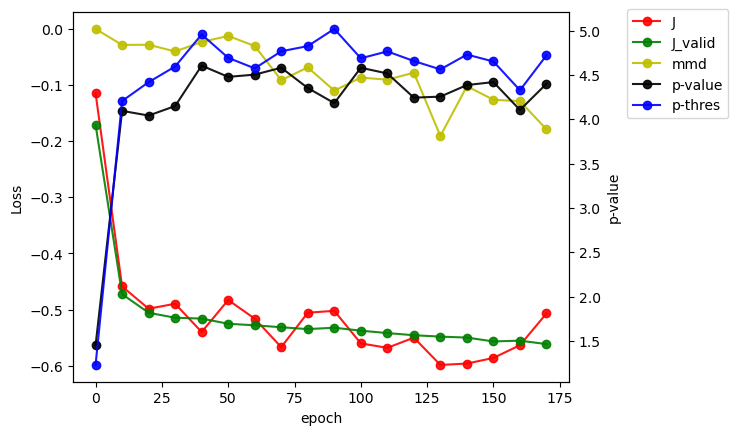

In [28]:

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(epoch_list, J_epoch[0,epoch_list], label='J', marker='o', alpha=0.9, color='r')
ax.plot(epoch_list, J_valid_epoch[epoch_list], label='J_valid', marker='o', alpha=0.9, color='g')
ax.plot(epoch_list, mmd_epoch[0,epoch_list], label='mmd', marker='o', alpha=0.9, color='y')
ax.set_ylabel("Loss")
ax2 = ax.twinx()
ax2.set_ylabel("p-value")
ax2.plot(epoch_list, p_epoch, label='p-value', marker='o', alpha=0.9, color='k')
ax2.plot(epoch_list, p_thres_epoch, label='p-thres', marker='o', alpha=0.9, color='b')
fig.legend(loc=1, bbox_to_anchor=(1.16,0.9))
ax.set_xlabel('epoch')
plt.savefig('loss_p_epoch.pdf')

# Trade-off of m-n-pi, fix pi=0.1
#

In [78]:
# 希望横轴是n，纵轴是m，固定3sigma，画pi的等高线
c = 11/np.sqrt(1100)
# 如果高斯近似，一个n上所有点都能算，对一个model我们需要P_mean, P_var, Q_mean
def get_gaussian_pval(n,m,pi,method=None, thres=False):
    i = np.where(ns==n)
    if method == 'MMD-L':
        return ps_L[i]*c*pi*np.sqrt(m)
    elif method == 'MMD-G':
        return ps_G[i]*c*pi*np.sqrt(m)
    elif method == 'MMD-O':
        return ps_O[i]*c*pi*np.sqrt(m)
    elif method == 'Scheffe':
        return ps_S[i]*c*pi*np.sqrt(m)
# MMD-L
path_dict_more = {    
    1600000: './checkpoint1600101/25/',
    1300000: './checkpoint1300101/25/',
    1000000: './checkpoint1000101/25/',
    700000: './checkpoint700001/40/',
    400000: './checkpoint400000/60/',
    100000: './checkpoint100000/60/',
    50000: './checkpoint50000/50/',
    10000: './checkpoint10000/170/',
    6000: './checkpoint6000/330/',
}
ps_L_more, ps_L_thres_more = get_ps(path_dict_more, 'MMD-L')

-------- start get_ps --------
epsilonOPT = tensor([-1.3849], device='cuda:0', requires_grad=True)
best thres p-val is  5.688387197054202
n = 1600000 , p-value = 4.909 p-value_thres = 5.688
epsilonOPT = tensor([-1.4320], device='cuda:0', requires_grad=True)
best thres p-val is  5.143123155441049
n = 1300000 , p-value = 4.664 p-value_thres = 5.143
epsilonOPT = tensor([-1.3806], device='cuda:0', requires_grad=True)
best thres p-val is  4.785952215304522
n = 1000000 , p-value = 4.465 p-value_thres = 4.786
epsilonOPT = tensor([-1.3838], device='cuda:0', requires_grad=True)
best thres p-val is  4.6278619555727145
n = 700000 , p-value = 4.461 p-value_thres = 4.628
epsilonOPT = tensor([-2.5230], device='cuda:0', requires_grad=True)
best thres p-val is  4.254042020237279
n = 400000 , p-value = 4.133 p-value_thres = 4.254
epsilonOPT = tensor([-2.7914], device='cuda:0', requires_grad=True)
best thres p-val is  3.300012667965505
n = 100000 , p-value = 3.423 p-value_thres = 3.300
epsilonOPT = tens

array(dict_keys([1600000, 1300000, 1000000, 700000, 400000, 100000, 50000, 10000, 6000]),
      dtype=object)

In [79]:
ns = np.array(list(path_dict.keys()))
ms = np.arange(100,1000,100)
Znm = np.zeros((len(ns), len(ms)))
# create empty df
df = pd.DataFrame(columns=['n','m','pi','p-value'])
# add data
for i,n in enumerate(ns):
    for j,m in enumerate(ms):
        pi = 5/ps_L_thres_more[i]/c/np.sqrt(m)
        Znm[i,j] = pi
        dict = {'n':n, 
                'm':m, 
                'pi':pi.item(), 
                'p-value': 5}
        df = df.append(dict, ignore_index=True)
        clear_output(wait = True)
# fig = px.scatter_3d(df, x='n', y='m', z='pi')
# fig.show()

/tmp/ipykernel_10940/2896534437.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict, ignore_index=True)


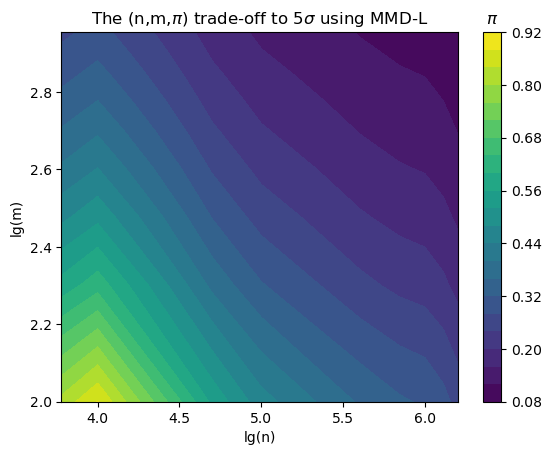

In [80]:
plt.contourf(np.log10(ns), np.log10(ms), Znm.T, levels=20)
plt.xlabel('lg(n)')
plt.ylabel('lg(m)')
clb = plt.colorbar()
clb.ax.set_title('$\pi$')
plt.title('The (n,m,$\pi$) trade-off to 5$\sigma$ using MMD-L')
plt.savefig('n_m_pi_trade-off.pdf')
plt.savefig('n_m_pi_trade-off.png')